<a href="https://colab.research.google.com/github/Hibah45/ResearchWork/blob/main/RFpruningMobilePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import cluster, datasets, mixture
from sklearn import metrics
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

fileURL = "https://github.com/Hibah45/ResearchWork/blob/main/MobilePricetrain.csv?raw=True"

data = pd.read_csv(fileURL)
data.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [23]:
data.shape

(2000, 21)

In [24]:
y = data['price_range']
# Create X
X = data.iloc[:,:-1]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# X, y = make_classification(n_samples=10, n_features=4,
#                            n_informative=2, n_redundant=0, 
#                            random_state=0, shuffle=False)
clf = RandomForestClassifier(n_estimators=100)
#clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


prec_rec = classification_report(y_pred, y_test)
print("CLASSIFICATION REPORT")
print(prec_rec)

Accuracy: 0.8766666666666667
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       156
           1       0.81      0.87      0.84       159
           2       0.83      0.83      0.83       143
           3       0.94      0.92      0.93       142

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



In [26]:
ind_tree = (clf.estimators_[4])
print(ind_tree)

DecisionTreeClassifier(max_features='auto', random_state=1383306309)


In [27]:
class PrunedRandomForest:


    def __init__(self, n_clusters = 10 , n_estimators = 300, cv = 5):
        """ this is the unpruned random forest """
        self.rf = RandomForestClassifier(n_estimators = n_estimators)

        """ this is the final pruned random forest """
        self.prf = None 
        self.prf1 = None 

        
        """this is a list of decision tree object present in original unpruned random forest"""
        self.decision_trees = None 
        
        """number of clusters for pruning"""
        self.n_clusters = n_clusters 
        
        

        """ 
            this contains dictionary of lists where each element of dictionary represetns a
            pair (cluster_idx, tree_idx_list)

            where tree_idx_list is list of decision tree indices and cluster_idx is index of cluster 
            e.g.
            
            {
                0 : [2, 0]
                1 : [1, 3]
            }
            it means decision tree at 2nd index and 0th index 
            are in same cluster similarly 1st and 3rd in second cluster

        """ 
        self.clusters = {}
        
        self.cv = cv


        """
            Information about all trees in the random forest present in this 
            form
            {
                idx : { 
                    accuracy : 89.34
                    cluster : 2
                }

                idx1 : {

                }
            }
        """
        self.info = {}
        #self.maxs_accuracy = {}
        self.fimps = None

    def prune(self):
        pass

    
    def fit(self, X, y):
        self.rf.fit(X,y)
        self.decision_trees = self.rf.estimators_
        self.create_feature_imp_clusters()
        self.create_feature_imp_clusters1()
        self.create_fimp_agglomerative()
        self.create_fimp_gaussian()
        self.create_fimp_spectral_clustering()
        #self.plot_clusters(X,y)
        #self.all_algorithms()

        self.fill_info(X, y)
        #self.max_accuracy(X,y)
        self.prune()

    def fill_info(self, X, y):
        for idx, tree in enumerate(self.decision_trees):
            self.info[idx] = self.fill_for_tree(tree, X, y)

        for cluster_idx in self.clusters:
            for tree_idx in self.clusters[cluster_idx]:
                self.info[tree_idx]["cluster_idx"] = cluster_idx 
       

    """
        {
            "accuracy" : 98.45,
            
        } 
    """


    def fill_for_tree(self, tree, X, y):
        info = {}
        mean_score = cross_val_score(tree, X, y, cv=self.cv).mean()
        info["accuracy"] = (mean_score)
        return info

    def predict(self, X):
        if(self.prf is None):
            return None
        
        return self.prf.predict(X)

    
    def get_decision_trees(self):
        return self.decision_trees

    def get_feature_imps_from_rf(self):
        feature_imp_list = []
        dts = self.get_decision_trees()
        for tree in dts:
            feature_imp_list.append(tree.feature_importances_)
        return feature_imp_list

    def create_feature_imp_clusters(self):
        fimps = self.get_feature_imps_from_rf()
        #print(fimps)
        #print("KMEANS")
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=0).fit(fimps)

        print(" fimps len = " + str(len(fimps)))
        labels = kmeans.labels_
        score = silhouette_score(fimps, labels, metric='euclidean')
        print('Silhouetter Score: %.3f' % score)
        #print(labels)
        print(" kmeans.labels_ len = " + str(len(kmeans.labels_)))
        for (tree_idx, cluster_idx) in enumerate(kmeans.labels_):
            if cluster_idx in self.clusters:
                self.clusters[cluster_idx].append(tree_idx)
            else:
                self.clusters[cluster_idx] = [tree_idx]
        
    def create_feature_imp_clusters1(self):
        fimps = self.get_feature_imps_from_rf()
        #print("DBSCAN-")
        dbscan = DBSCAN().fit(fimps)

        print(" fimps len = " + str(len(fimps)))
        labels = dbscan.labels_
        #print(labels)
        print(" dbscan.labels_ len = " + str(len(labels)))
        

    def create_fimp_agglomerative(self):
        fimps = self.get_feature_imps_from_rf()
        #print("AGGLOMERATIVE CLUSTERING-")
        groups = AgglomerativeClustering(n_clusters=self.n_clusters).fit(fimps)
        #print(groups.labels_)

    def create_fimp_gaussian(self):
      fimps = self.get_feature_imps_from_rf()
      #print("GAUSSIAN CLUSTERING-")
      gmm =GaussianMixture(n_components = 5)
      gmm.fit(fimps)
      labelsgmm = gmm.predict(fimps)
      #print(labelsgmm)
      
    def create_fimp_spectral_clustering(self):
      fimps = self.get_feature_imps_from_rf()
      models = SpectralClustering(n_clusters=6, random_state=25, n_neighbors=8, affinity='nearest_neighbors')
      models.fit(fimps)
      labelsx = models.fit_predict(fimps)
      #print(labelsx)


In [28]:
prf = PrunedRandomForest(10, 300)
prf.fit(X, y)
print('KMEANS-')
for cluster_idx in prf.clusters:
          print(str(cluster_idx) + " ==> ", prf.clusters[cluster_idx])

prf1 = PrunedRandomForest()
prf1.fit(X, y)
print('DBSCAN-')
for cluster_idx in prf1.clusters:
          print(str(cluster_idx) + " ==> ", prf1.clusters[cluster_idx])

prf2 = PrunedRandomForest()
prf2.fit(X, y)
print('AGGLO')
for cluster_idx in prf2.clusters:
          print(str(cluster_idx) + " ==> ", prf2.clusters[cluster_idx])

prf3 = PrunedRandomForest()
prf3.fit(X,y)
print('Gaussian')
for cluster_idx in prf3.clusters:
          print(str(cluster_idx) + " ==> ", prf3.clusters[cluster_idx])

prf4 = PrunedRandomForest()
prf4.fit(X,y)
print('spectral clustering')
for cluster_idx in prf4.clusters:
          print(str(cluster_idx) + " ==> ", prf4.clusters[cluster_idx])


 fimps len = 100
Silhouetter Score: 0.203
 kmeans.labels_ len = 100
 fimps len = 100
 dbscan.labels_ len = 100
KMEANS-
3 ==>  [0, 4, 8, 19, 21, 22, 30, 33, 35, 37, 39, 41, 43, 46, 50, 52, 55, 59, 64, 75, 79, 80, 83, 88, 89, 92]
2 ==>  [1, 3, 6, 10, 18, 49, 54, 63, 65, 67, 74, 95]
0 ==>  [2, 11, 15, 16, 17, 23, 27, 28, 32, 34, 36, 38, 42, 48, 53, 57, 58, 61, 76, 86, 87]
4 ==>  [5, 12, 14, 24, 25, 26, 29, 60, 66, 73, 90, 91, 94, 96]
1 ==>  [7, 9, 13, 20, 44, 45, 56, 77, 84, 85, 93, 97]
5 ==>  [31, 40, 47, 51, 62, 68, 69, 70, 71, 72, 78, 81, 82, 98, 99]
 fimps len = 100
Silhouetter Score: 0.204
 kmeans.labels_ len = 100
 fimps len = 100
 dbscan.labels_ len = 100
DBSCAN-
3 ==>  [0, 10, 11, 29, 38, 41, 43, 49, 52, 53, 64, 70, 72, 78, 81, 98]
1 ==>  [1, 16, 20, 22, 24, 25, 26, 28, 30, 32, 34, 35, 36, 37, 39, 40, 42, 50, 51, 56, 62, 71, 74, 75, 80, 86, 87, 91, 96]
5 ==>  [2, 3, 8, 19, 21, 33, 46, 57, 59, 61, 63, 66, 68, 69, 77, 82, 84, 85, 89, 93, 99]
2 ==>  [4, 17, 27, 44, 45, 48, 54, 55, 60

In [29]:
  # def plot_clusters(model, X):
  #     pred = model.fit(X)
  #     clusters = unique(pred)
  #     for cluster in clusters:
  #       row_idx = where(pred == cluster)
  #       # create scatter of these samples
  #       col0 = getColumn(X, row_idx, 0)
  #       col1 = getColumn(X, row_idx, 1)
  #       pyplot.scatter(col0, col1)
  #   # show the plot
  #   pyplot.show()

  #   def all_algorithms(self):
  #       fimps = self.get_feature_imps_from_rf()
  #       print("KMEANS")
  #       kmeans = self.plot_clusters(KMeans(n_clusters=self.n_clusters, random_state=0), fimps)
  #       print("DBSCAN-")
  #       dbscan = self.plot_clusters(DBSCAN(), fimps)
  #       print("AGGLOMERATIVE CLUSTERING-")
  #       groups = self.plot_clusters(AgglomerativeClustering(n_clusters=self.n_clusters), fimps)
  #       print(" fimps len = " + str(len(fimps)))
  #       #print(labels)
  #       print(" kmeans.labels_ len = " + str(len(kmeans.labels_)))

AgglomerativeClustering(n_clusters=4)

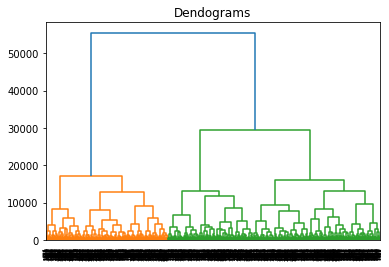

In [30]:
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
groups = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage="ward")
groups.fit(X)

In [31]:
prf.info

{0: {'accuracy': 0.6775, 'cluster_idx': 3},
 1: {'accuracy': 0.7144999999999999, 'cluster_idx': 2},
 2: {'accuracy': 0.6585000000000001, 'cluster_idx': 0},
 3: {'accuracy': 0.6575, 'cluster_idx': 2},
 4: {'accuracy': 0.6475000000000001, 'cluster_idx': 3},
 5: {'accuracy': 0.639, 'cluster_idx': 4},
 6: {'accuracy': 0.65, 'cluster_idx': 2},
 7: {'accuracy': 0.5645, 'cluster_idx': 1},
 8: {'accuracy': 0.6525000000000001, 'cluster_idx': 3},
 9: {'accuracy': 0.5735, 'cluster_idx': 1},
 10: {'accuracy': 0.739, 'cluster_idx': 2},
 11: {'accuracy': 0.7030000000000001, 'cluster_idx': 0},
 12: {'accuracy': 0.6100000000000001, 'cluster_idx': 4},
 13: {'accuracy': 0.5705, 'cluster_idx': 1},
 14: {'accuracy': 0.6565, 'cluster_idx': 4},
 15: {'accuracy': 0.7024999999999999, 'cluster_idx': 0},
 16: {'accuracy': 0.6105, 'cluster_idx': 0},
 17: {'accuracy': 0.6724999999999999, 'cluster_idx': 0},
 18: {'accuracy': 0.607, 'cluster_idx': 2},
 19: {'accuracy': 0.62, 'cluster_idx': 3},
 20: {'accuracy': 0.5

In [32]:
max_acc = -1
max_acc_in_cluster = -1
idx = ""
lists = []
list1 = []
res = set()
dicts = prf.info
for k, subdict in dicts.items():
      res.add(subdict['cluster_idx'])
      if subdict['accuracy'] >= max_acc:
        max_acc = subdict['accuracy']
        idx = subdict['cluster_idx']
        lists.append([max_acc,idx, k])
        for i in range(len(res)):
          if i == idx:
            list1.append([i,max_acc,k])

print(max_acc, idx)
result = set([c for a, c, t in lists])
result
print("List of clusters with maximum accuracy is:\n")
print("Cluster index,Maximum accuracy,decision tree\n",sorted(list1))

#for each cluster get max acc nd tree to be selected as representsative
#once all the cluster representatives are found ..remove all others ..prune function
# calculated overall performance of random forest again-challenging

0.7464999999999999 0
List of clusters with maximum accuracy is:

Cluster index,Maximum accuracy,decision tree
 [[0, 0.7464999999999999, 27], [2, 0.739, 10]]


In [33]:
# Highest acuracy selection-Cluster Representative
def getMaxAccuracyCluster(dicts):
    clusterObj = {}
    for key, value in dicts.items():
      if(clusterObj.get(str(value["cluster_idx"])) != None):
        clusterObj[str(value["cluster_idx"])].append({"index" : key, "accuracy" : value['accuracy']})
      else:
        clusterObj[str(value["cluster_idx"])] = []
        clusterObj[str(value["cluster_idx"])].append({"index" : key, "accuracy" : value['accuracy']})
    #Restructured the object so the key for dictionary is cluster_idx
    #Now you can access all the accuracies of cluster as below
    #print(clusterObj["2"])
    clusterMaxAccuracyObj = {}
    for clusterIndex in clusterObj.keys():
      max_acc = -1;
      for obj in clusterObj[clusterIndex]:
        if obj['accuracy'] == max_acc:
          clusterMaxAccuracyObj[str(clusterIndex)].append(obj['index'])
        if obj['accuracy'] > max_acc:
          max_acc = obj['accuracy']
          clusterMaxAccuracyObj[str(clusterIndex)] = []
          clusterMaxAccuracyObj[str(clusterIndex)].append(obj['index'])
    print(clusterMaxAccuracyObj)
    dict1 = {}
    print("Selecting first maximum accuracy of a decision tree in each cluster:")
    for key,val in clusterMaxAccuracyObj.items():
      output = {key : val[0]}
      print(output)
    return clusterMaxAccuracyObj

In [34]:
getMaxAccuracyCluster(prf.info)

{'3': [75], '2': [10], '0': [27], '4': [24], '1': [85], '5': [47]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'3': 75}
{'2': 10}
{'0': 27}
{'4': 24}
{'1': 85}
{'5': 47}


{'0': [27], '1': [85], '2': [10], '3': [75], '4': [24], '5': [47]}

In [35]:
prf.decision_trees[0].predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1., 2., 2., ..., 3., 0., 3.])

In [36]:
def getTreeList(X, dicts):
    treeIdxs = []
    for trees in dicts.values():
        treeIdxs.append(trees[0])
    return treeIdxs

stored_ypred = []
def predict(X, treeList, prf):
    ypred = []
    for treeIdx in treeList:
        print(prf.decision_trees[treeIdx].predict(X))
        ypred.append(prf.decision_trees[treeIdx].predict(X))
    stored_ypred.append(ypred)
    print(type(ypred))
    return getMajorityLabels(ypred)

def getMajorityLabels(pred):
    predNp = np.array(pred)
    rows,cols = predNp.shape
    res = []
    for colIdx in range(cols):
        col = list(predNp[:, colIdx])
        res.append(max(set(col), key = col.count))
    return res




In [37]:
treeList = getTreeList(X, getMaxAccuracyCluster(prf.info))

y_preed = predict(X_test, treeList, prf)

print("final answer = ", y_preed)
  
print("testing target data:",y_test)
  
print("Accuracy:",metrics.accuracy_score(y_test, y_preed))

{'3': [75], '2': [10], '0': [27], '4': [24], '1': [85], '5': [47]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'3': 75}
{'2': 10}
{'0': 27}
{'4': 24}
{'1': 85}
{'5': 47}
[1. 1. 3. 3. 1. 2. 1. 0. 2. 2. 1. 2. 2. 0. 1. 3. 0. 1. 0. 2. 0. 0. 3. 1.
 3. 2. 3. 0. 2. 3. 1. 1. 0. 1. 0. 0. 2. 2. 1. 0. 0. 1. 0. 0. 1. 0. 3. 2.
 3. 3. 3. 2. 1. 1. 0. 1. 2. 2. 3. 3. 0. 0. 3. 2. 0. 2. 3. 0. 1. 3. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 2. 3. 1. 0. 2. 2. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 2. 0. 3. 1. 2. 1. 1. 0. 2. 1. 1. 1. 2. 0. 0. 1. 0. 3. 3. 3. 3. 3. 3.
 2. 0. 0. 2. 2. 0. 3. 2. 2. 1. 0. 0. 0. 0. 2. 2. 1. 3. 2. 3. 0. 2. 3. 0.
 1. 0. 1. 2. 2. 2. 0. 3. 3. 3. 3. 1. 3. 0. 1. 1. 3. 1. 0. 3. 3. 0. 2. 3.
 2. 0. 2. 1. 0. 1. 3. 0. 2. 2. 0. 3. 0. 1. 2. 0. 2. 0. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 3. 3. 1. 2. 2. 0. 2. 0. 1. 1. 0. 3. 3. 3. 3. 1. 1. 2. 0. 0. 0.
 2. 0. 0. 3. 2. 1. 1. 3. 3. 2. 1. 3. 0. 3. 1. 3. 1. 3. 0. 3. 2. 0. 2. 0.
 1. 0. 3. 3. 2. 0. 2. 3. 0. 3. 0. 2. 3. 0. 1. 1. 2. 2. 0. 3. 1. 0. 1. 0.
 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

Most repeated accuracy selection-Mode
Average accuracy selection-mean
Choosing the middle value after sorting the accuracy-median
Apart from accuracy-what else can be chosen for performance evaluation in decision tree???
Next step? Pruning? How to evaluate performance after pruning?


In [38]:
prf1.info

{0: {'accuracy': 0.7675, 'cluster_idx': 3},
 1: {'accuracy': 0.5575, 'cluster_idx': 1},
 2: {'accuracy': 0.5805, 'cluster_idx': 5},
 3: {'accuracy': 0.6385000000000001, 'cluster_idx': 5},
 4: {'accuracy': 0.562, 'cluster_idx': 2},
 5: {'accuracy': 0.627, 'cluster_idx': 0},
 6: {'accuracy': 0.6174999999999999, 'cluster_idx': 0},
 7: {'accuracy': 0.534, 'cluster_idx': 0},
 8: {'accuracy': 0.624, 'cluster_idx': 5},
 9: {'accuracy': 0.617, 'cluster_idx': 4},
 10: {'accuracy': 0.662, 'cluster_idx': 3},
 11: {'accuracy': 0.7324999999999999, 'cluster_idx': 3},
 12: {'accuracy': 0.5885, 'cluster_idx': 0},
 13: {'accuracy': 0.6905, 'cluster_idx': 0},
 14: {'accuracy': 0.5774999999999999, 'cluster_idx': 0},
 15: {'accuracy': 0.5415, 'cluster_idx': 0},
 16: {'accuracy': 0.5814999999999999, 'cluster_idx': 1},
 17: {'accuracy': 0.5545, 'cluster_idx': 2},
 18: {'accuracy': 0.6125, 'cluster_idx': 0},
 19: {'accuracy': 0.603, 'cluster_idx': 5},
 20: {'accuracy': 0.7420000000000001, 'cluster_idx': 1},


In [39]:
#dbscan
getMaxAccuracyCluster(prf1.info)

{'3': [0], '1': [42], '5': [66], '2': [67], '0': [13], '4': [73]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'3': 0}
{'1': 42}
{'5': 66}
{'2': 67}
{'0': 13}
{'4': 73}


{'0': [13], '1': [42], '2': [67], '3': [0], '4': [73], '5': [66]}

In [40]:
treeList = getTreeList(X, getMaxAccuracyCluster(prf1.info))

y_preed = predict(X_test, treeList, prf1)

print("final answer = ", y_preed)
print(y_test)
  
print("Accuracy:",metrics.accuracy_score(y_test, y_preed))

{'3': [0], '1': [42], '5': [66], '2': [67], '0': [13], '4': [73]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'3': 0}
{'1': 42}
{'5': 66}
{'2': 67}
{'0': 13}
{'4': 73}
[1. 1. 3. 3. 1. 2. 1. 0. 2. 2. 3. 2. 2. 0. 1. 3. 0. 1. 0. 3. 0. 1. 3. 1.
 3. 2. 3. 0. 2. 3. 1. 1. 0. 1. 0. 0. 2. 2. 1. 0. 0. 1. 0. 0. 1. 0. 3. 2.
 3. 3. 3. 2. 1. 2. 0. 1. 2. 1. 3. 3. 0. 0. 3. 2. 0. 3. 3. 0. 1. 3. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 3. 1. 0. 2. 0. 0. 1. 1. 0. 0. 1. 1. 2.
 0. 3. 1. 1. 1. 1. 1. 2. 0. 3. 1. 1. 1. 2. 0. 0. 1. 0. 3. 3. 3. 2. 3. 3.
 2. 0. 0. 2. 3. 0. 3. 2. 2. 1. 1. 0. 0. 0. 2. 2. 1. 3. 2. 3. 0. 2. 3. 0.
 1. 0. 1. 2. 2. 1. 0. 2. 2. 3. 2. 1. 3. 0. 0. 1. 3. 1. 0. 2. 3. 1. 2. 3.
 3. 0. 2. 1. 0. 1. 2. 0. 2. 3. 0. 3. 0. 1. 3. 0. 2. 0. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 3. 3. 0. 2. 2. 0. 2. 0. 1. 1. 0. 3. 3. 3. 3. 1. 2. 2. 0. 0. 0.
 2. 0. 0. 2. 2. 1. 1. 3. 3. 3. 1. 3. 0. 3. 1. 2. 1. 2. 1. 3. 2. 1. 2. 1.
 1. 0. 2. 3. 2. 0. 3. 3. 0. 2. 0. 2. 3. 0. 2. 0. 1. 2. 0. 2. 1. 1. 1. 0.
 3.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

[0. 1. 3. 3. 1. 3. 1. 0. 2. 2. 1. 2. 2. 0. 1. 3. 1. 0. 0. 3. 0. 1. 3. 1.
 3. 2. 3. 0. 2. 3. 1. 0. 0. 1. 1. 0. 2. 2. 1. 0. 0. 1. 0. 0. 1. 0. 3. 2.
 3. 3. 3. 2. 0. 2. 0. 1. 2. 1. 3. 3. 0. 0. 3. 2. 0. 2. 3. 0. 1. 2. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 2. 2. 3. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 2.
 0. 2. 1. 1. 1. 1. 1. 3. 1. 3. 1. 1. 1. 2. 0. 2. 1. 0. 3. 3. 2. 3. 3. 3.
 2. 0. 0. 3. 3. 0. 3. 2. 2. 1. 1. 0. 1. 0. 2. 2. 1. 3. 3. 3. 0. 2. 3. 0.
 1. 0. 1. 2. 2. 0. 0. 3. 2. 3. 3. 1. 3. 0. 1. 1. 1. 1. 0. 3. 3. 1. 2. 3.
 3. 0. 0. 1. 0. 2. 2. 0. 2. 3. 0. 3. 0. 1. 2. 1. 2. 0. 0. 0. 2. 3. 0. 1.
 2. 3. 3. 2. 3. 1. 1. 2. 0. 2. 0. 1. 1. 0. 2. 3. 3. 3. 1. 1. 2. 0. 0. 0.
 1. 0. 1. 3. 2. 1. 1. 3. 3. 2. 1. 3. 0. 3. 1. 3. 1. 3. 0. 3. 3. 1. 2. 1.
 1. 0. 3. 3. 2. 0. 3. 2. 0. 3. 0. 1. 3. 0. 1. 0. 2. 2. 0. 3. 2. 0. 0. 0.
 2. 1. 1. 0. 3. 3. 2. 3. 2. 2. 2. 2. 3. 1. 2. 3. 0. 0. 3. 3. 0. 1. 1. 2.
 1. 0. 0. 1. 2. 2. 1. 2. 3. 1. 0. 1. 2. 3. 3. 2. 0. 3. 0. 2. 3. 2. 1. 0.
 0. 2. 1. 1. 1. 3. 3. 1. 1. 1. 1. 2. 2. 0. 1. 0. 1.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


sample->output(class label)

list of samples(vectors)->list of classes-predicted ones

actual values->target 

compare(target,predicted)->accuracy

compare the accuracy of 100 trees using random forest and the accuracy of 6 trees formed in the end

aprt from accuracy, most seperated distance between two decision trees in each cluster

In [41]:
prf2.info

{0: {'accuracy': 0.6020000000000001, 'cluster_idx': 0},
 1: {'accuracy': 0.6295, 'cluster_idx': 3},
 2: {'accuracy': 0.614, 'cluster_idx': 1},
 3: {'accuracy': 0.6615, 'cluster_idx': 0},
 4: {'accuracy': 0.6295, 'cluster_idx': 1},
 5: {'accuracy': 0.6605000000000001, 'cluster_idx': 1},
 6: {'accuracy': 0.5815, 'cluster_idx': 2},
 7: {'accuracy': 0.6054999999999999, 'cluster_idx': 2},
 8: {'accuracy': 0.7554999999999998, 'cluster_idx': 3},
 9: {'accuracy': 0.6255000000000001, 'cluster_idx': 2},
 10: {'accuracy': 0.6195, 'cluster_idx': 2},
 11: {'accuracy': 0.589, 'cluster_idx': 2},
 12: {'accuracy': 0.609, 'cluster_idx': 2},
 13: {'accuracy': 0.6475000000000001, 'cluster_idx': 2},
 14: {'accuracy': 0.6325000000000001, 'cluster_idx': 3},
 15: {'accuracy': 0.5795, 'cluster_idx': 2},
 16: {'accuracy': 0.6385, 'cluster_idx': 1},
 17: {'accuracy': 0.5349999999999999, 'cluster_idx': 2},
 18: {'accuracy': 0.6685, 'cluster_idx': 1},
 19: {'accuracy': 0.6214999999999999, 'cluster_idx': 0},
 20: 

In [42]:
#agglo
getMaxAccuracyCluster(prf2.info)

{'0': [3], '3': [32], '1': [37], '2': [95]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'0': 3}
{'3': 32}
{'1': 37}
{'2': 95}


{'0': [3], '1': [37], '2': [95], '3': [32]}

In [43]:
treeList = getTreeList(X, getMaxAccuracyCluster(prf2.info))

y_preed = predict(X_test, treeList, prf2)

print("final answer = ", y_preed)
print(y_test)
  
print("Accuracy:",metrics.accuracy_score(y_test, y_preed))

{'0': [3], '3': [32], '1': [37], '2': [95]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'0': 3}
{'3': 32}
{'1': 37}
{'2': 95}
[1. 1. 2. 2. 1. 2. 1. 0. 1. 3. 1. 2. 2. 0. 0. 3. 0. 1. 0. 2. 0. 0. 3. 1.
 3. 3. 3. 0. 2. 3. 1. 1. 0. 1. 1. 0. 2. 2. 1. 0. 1. 1. 0. 0. 2. 0. 3. 2.
 3. 3. 3. 2. 1. 2. 0. 1. 2. 1. 3. 3. 2. 2. 1. 2. 0. 2. 3. 0. 1. 2. 0. 2.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 3. 1. 0. 2. 0. 0. 1. 3. 0. 0. 2. 1. 1.
 0. 2. 1. 1. 1. 1. 1. 2. 0. 3. 1. 1. 1. 2. 1. 0. 1. 0. 3. 2. 3. 2. 2. 3.
 2. 0. 0. 2. 3. 0. 3. 1. 2. 1. 1. 0. 1. 0. 3. 2. 1. 3. 2. 2. 0. 2. 3. 0.
 1. 0. 2. 2. 2. 2. 0. 3. 2. 3. 3. 1. 3. 0. 1. 1. 3. 1. 1. 2. 3. 0. 2. 3.
 3. 0. 2. 2. 0. 1. 3. 0. 2. 1. 0. 3. 0. 1. 2. 0. 2. 1. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 3. 2. 1. 1. 2. 0. 2. 0. 1. 1. 0. 3. 3. 3. 2. 2. 1. 1. 1. 0. 0.
 2. 0. 1. 3. 2. 1. 1. 3. 3. 3. 1. 3. 0. 3. 1. 3. 1. 3. 0. 3. 2. 1. 0. 1.
 1. 0. 3. 3. 2. 0. 3. 3. 0. 3. 0. 2. 3. 0. 1. 0. 2. 2. 0. 3. 1. 0. 1. 0.
 2. 1. 0. 0. 3. 2. 2. 2. 2. 2. 3. 2. 3. 0. 2.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

<class 'list'>
final answer =  [1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 3.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 3.0, 1.0, 3.0, 2.0, 3.0, 0.0, 2.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 3.0, 3.0, 0.0, 0.0, 3.0, 2.0, 0.0, 2.0, 3.0, 0.0, 1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 3.0, 1.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 3.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 0.0, 0.0, 2.0, 3.0, 0.0, 3.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 3.0, 2.0, 2.0, 0.0, 2.0, 3.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 3.0, 2.0, 3.0, 3.0, 1.0, 3.0, 0.0, 1.0, 1.0, 3.0, 1.0, 0.0, 2.0, 3.0, 0.0, 2.0, 3.0, 3.0, 0.0, 2.0, 1.0, 0.0, 1.0, 3.0, 0.0, 2.0, 3.0, 0.0, 3.0, 0.0, 1.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 1.0, 2.0, 2.0

In [44]:
prf3.info

{0: {'accuracy': 0.7135, 'cluster_idx': 4},
 1: {'accuracy': 0.603, 'cluster_idx': 1},
 2: {'accuracy': 0.591, 'cluster_idx': 3},
 3: {'accuracy': 0.7115, 'cluster_idx': 0},
 4: {'accuracy': 0.5615, 'cluster_idx': 0},
 5: {'accuracy': 0.5675000000000001, 'cluster_idx': 2},
 6: {'accuracy': 0.5735, 'cluster_idx': 3},
 7: {'accuracy': 0.677, 'cluster_idx': 0},
 8: {'accuracy': 0.6105, 'cluster_idx': 4},
 9: {'accuracy': 0.6655, 'cluster_idx': 4},
 10: {'accuracy': 0.7195, 'cluster_idx': 1},
 11: {'accuracy': 0.5930000000000001, 'cluster_idx': 2},
 12: {'accuracy': 0.5855, 'cluster_idx': 2},
 13: {'accuracy': 0.6759999999999999, 'cluster_idx': 2},
 14: {'accuracy': 0.6125, 'cluster_idx': 4},
 15: {'accuracy': 0.6855, 'cluster_idx': 2},
 16: {'accuracy': 0.6685, 'cluster_idx': 4},
 17: {'accuracy': 0.744, 'cluster_idx': 2},
 18: {'accuracy': 0.5700000000000001, 'cluster_idx': 4},
 19: {'accuracy': 0.528, 'cluster_idx': 3},
 20: {'accuracy': 0.5539999999999999, 'cluster_idx': 3},
 21: {'acc

In [45]:
#gaussian
getMaxAccuracyCluster(prf3.info)

{'4': [89], '1': [10], '3': [97], '0': [74], '2': [87]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'4': 89}
{'1': 10}
{'3': 97}
{'0': 74}
{'2': 87}


{'0': [74], '1': [10], '2': [87], '3': [97], '4': [89]}

In [46]:
treeList = getTreeList(X, getMaxAccuracyCluster(prf3.info))

y_preed = predict(X_test, treeList, prf3)

print("final answer = ", y_preed)
print(y_test)
  
print("Accuracy:",metrics.accuracy_score(y_test, y_preed))

{'4': [89], '1': [10], '3': [97], '0': [74], '2': [87]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'4': 89}
{'1': 10}
{'3': 97}
{'0': 74}
{'2': 87}
[1. 1. 3. 3. 0. 2. 1. 0. 0. 2. 1. 2. 2. 0. 1. 3. 0. 0. 0. 2. 0. 1. 3. 1.
 3. 2. 3. 0. 2. 3. 2. 1. 0. 1. 1. 0. 2. 2. 1. 0. 0. 1. 1. 0. 0. 0. 3. 2.
 3. 3. 3. 2. 1. 2. 0. 1. 3. 1. 3. 3. 0. 0. 3. 2. 0. 2. 3. 0. 2. 3. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 2. 1. 3. 0. 0. 3. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 2. 1. 1. 1. 1. 1. 2. 0. 3. 1. 1. 1. 2. 0. 0. 1. 0. 3. 3. 3. 3. 3. 3.
 2. 0. 0. 3. 3. 1. 3. 2. 1. 3. 0. 0. 1. 0. 2. 2. 1. 3. 2. 3. 0. 2. 3. 0.
 1. 0. 1. 2. 2. 2. 0. 3. 2. 3. 2. 1. 2. 0. 1. 1. 3. 1. 0. 2. 3. 0. 3. 3.
 3. 0. 2. 1. 0. 1. 3. 0. 1. 3. 0. 3. 0. 1. 2. 0. 3. 0. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 2. 3. 0. 2. 2. 0. 2. 0. 1. 1. 0. 3. 3. 3. 3. 1. 1. 2. 0. 0. 0.
 1. 1. 1. 3. 2. 1. 2. 3. 3. 2. 1. 3. 0. 2. 1. 3. 1. 3. 0. 3. 2. 1. 2. 1.
 0. 0. 3. 3. 3. 0. 3. 3. 0. 3. 0. 2. 3. 0. 1. 2. 1. 3. 0. 3. 1. 1. 1. 1.
 2. 1. 0. 0. 3. 2. 2. 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

[1. 1. 3. 3. 1. 2. 1. 0. 2. 2. 1. 2. 2. 0. 1. 3. 0. 1. 0. 3. 0. 0. 3. 1.
 3. 2. 3. 0. 2. 3. 1. 2. 0. 1. 0. 0. 2. 2. 1. 0. 0. 1. 0. 0. 0. 0. 3. 2.
 3. 2. 3. 3. 2. 2. 0. 1. 2. 1. 3. 3. 0. 0. 3. 2. 0. 3. 2. 0. 1. 3. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 3. 0. 0. 3. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 0. 2. 1. 1. 1. 1. 1. 2. 1. 3. 1. 1. 1. 2. 0. 0. 1. 0. 3. 2. 3. 2. 3. 3.
 2. 0. 0. 2. 2. 0. 3. 2. 2. 1. 1. 0. 1. 0. 2. 2. 1. 3. 2. 3. 0. 2. 3. 0.
 1. 0. 1. 2. 2. 2. 0. 3. 3. 3. 3. 1. 1. 0. 0. 0. 3. 1. 0. 3. 3. 1. 2. 3.
 3. 0. 2. 1. 0. 1. 3. 0. 1. 3. 0. 3. 0. 2. 2. 0. 2. 0. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 3. 3. 1. 2. 2. 0. 2. 0. 1. 1. 0. 3. 3. 1. 3. 1. 1. 2. 0. 0. 0.
 2. 0. 1. 3. 2. 2. 1. 3. 3. 3. 1. 3. 0. 2. 1. 2. 1. 3. 0. 3. 2. 0. 2. 1.
 1. 0. 3. 2. 2. 0. 3. 3. 1. 3. 0. 2. 3. 0. 2. 0. 2. 2. 0. 3. 1. 1. 1. 0.
 2. 1. 0. 0. 3. 2. 2. 2. 2. 2. 2. 1. 3. 0. 2. 3. 1. 0. 3. 3. 0. 2. 1. 1.
 1. 0. 0. 1. 1. 2. 1. 2. 2. 0. 1. 0. 2. 3. 3. 2. 0. 2. 0. 2. 3. 2. 0. 0.
 0. 3. 1. 1. 1. 3. 3. 1. 1. 1. 1. 2. 1. 0. 1. 0. 0.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [47]:
prf4.info

{0: {'accuracy': 0.615, 'cluster_idx': 4},
 1: {'accuracy': 0.5900000000000001, 'cluster_idx': 1},
 2: {'accuracy': 0.5894999999999999, 'cluster_idx': 2},
 3: {'accuracy': 0.624, 'cluster_idx': 2},
 4: {'accuracy': 0.611, 'cluster_idx': 2},
 5: {'accuracy': 0.6075, 'cluster_idx': 1},
 6: {'accuracy': 0.554, 'cluster_idx': 2},
 7: {'accuracy': 0.5900000000000001, 'cluster_idx': 4},
 8: {'accuracy': 0.5984999999999999, 'cluster_idx': 1},
 9: {'accuracy': 0.6305, 'cluster_idx': 4},
 10: {'accuracy': 0.587, 'cluster_idx': 5},
 11: {'accuracy': 0.575, 'cluster_idx': 1},
 12: {'accuracy': 0.6449999999999999, 'cluster_idx': 2},
 13: {'accuracy': 0.6035, 'cluster_idx': 2},
 14: {'accuracy': 0.524, 'cluster_idx': 4},
 15: {'accuracy': 0.5745, 'cluster_idx': 2},
 16: {'accuracy': 0.6185, 'cluster_idx': 0},
 17: {'accuracy': 0.617, 'cluster_idx': 1},
 18: {'accuracy': 0.5545, 'cluster_idx': 1},
 19: {'accuracy': 0.585, 'cluster_idx': 1},
 20: {'accuracy': 0.6385000000000001, 'cluster_idx': 1},
 2

In [48]:
#spectral
getMaxAccuracyCluster(prf4.info)

{'4': [77], '1': [73], '2': [12], '5': [37], '0': [91], '3': [96]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'4': 77}
{'1': 73}
{'2': 12}
{'5': 37}
{'0': 91}
{'3': 96}


{'0': [91], '1': [73], '2': [12], '3': [96], '4': [77], '5': [37]}

In [49]:
treeList = getTreeList(X, getMaxAccuracyCluster(prf4.info))

y_preed = predict(X_test, treeList, prf4)

print("final answer = ", y_preed)
print(y_test)
  
print("Accuracy:",metrics.accuracy_score(y_test, y_preed))

{'4': [77], '1': [73], '2': [12], '5': [37], '0': [91], '3': [96]}
Selecting first maximum accuracy of a decision tree in each cluster:
{'4': 77}
{'1': 73}
{'2': 12}
{'5': 37}
{'0': 91}
{'3': 96}
[1. 1. 3. 3. 1. 2. 1. 0. 2. 2. 1. 1. 2. 0. 1. 3. 0. 1. 0. 2. 0. 1. 3. 1.
 3. 2. 3. 0. 2. 3. 1. 1. 0. 1. 1. 0. 2. 2. 1. 0. 0. 1. 0. 0. 1. 1. 3. 2.
 3. 3. 3. 2. 1. 2. 0. 0. 2. 1. 3. 3. 0. 0. 3. 2. 0. 2. 3. 0. 1. 3. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 2. 2. 3. 1. 0. 3. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 2. 2. 1. 1. 2. 1. 2. 0. 3. 1. 1. 1. 3. 0. 0. 1. 0. 3. 3. 3. 1. 3. 3.
 2. 0. 0. 0. 3. 0. 3. 2. 2. 1. 1. 0. 0. 0. 2. 2. 1. 3. 2. 3. 0. 2. 3. 0.
 2. 0. 0. 2. 2. 2. 0. 3. 2. 3. 3. 1. 3. 0. 1. 1. 1. 1. 0. 2. 3. 0. 1. 2.
 3. 0. 2. 1. 0. 1. 3. 0. 2. 3. 1. 3. 0. 1. 2. 0. 2. 0. 0. 0. 2. 3. 0. 1.
 2. 2. 3. 3. 3. 1. 2. 2. 0. 2. 0. 1. 1. 0. 3. 3. 3. 3. 1. 1. 2. 0. 0. 0.
 2. 0. 1. 3. 2. 1. 1. 3. 3. 3. 1. 3. 0. 3. 1. 3. 1. 3. 0. 3. 2. 1. 3. 1.
 1. 0. 3. 3. 2. 0. 3. 3. 0. 3. 0. 2. 3. 0. 1. 0. 2. 2. 0. 3. 1. 0. 1. 0.
 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has featu

[1. 1. 3. 3. 1. 2. 1. 1. 2. 2. 1. 3. 3. 0. 1. 3. 0. 3. 0. 2. 1. 0. 3. 0.
 3. 1. 3. 0. 2. 3. 1. 3. 0. 1. 1. 0. 0. 1. 1. 0. 3. 1. 0. 0. 1. 0. 3. 3.
 3. 3. 3. 0. 1. 2. 0. 1. 2. 1. 1. 1. 0. 0. 1. 2. 2. 2. 3. 0. 1. 3. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 2. 2. 3. 1. 0. 3. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 2. 1. 1. 1. 1. 1. 1. 0. 3. 1. 1. 1. 2. 3. 0. 1. 0. 2. 3. 3. 3. 3. 3.
 3. 0. 1. 2. 3. 0. 3. 3. 2. 1. 1. 0. 2. 0. 2. 3. 1. 3. 2. 3. 0. 2. 0. 0.
 1. 2. 0. 2. 2. 2. 0. 3. 2. 3. 3. 0. 3. 2. 1. 0. 3. 1. 1. 1. 3. 2. 2. 3.
 3. 0. 2. 1. 0. 1. 3. 1. 2. 3. 0. 3. 3. 1. 2. 0. 2. 0. 0. 0. 2. 3. 0. 1.
 0. 2. 3. 3. 3. 1. 3. 2. 0. 2. 0. 1. 1. 3. 3. 3. 3. 3. 2. 1. 2. 0. 3. 0.
 2. 0. 1. 0. 2. 1. 1. 3. 3. 3. 2. 2. 0. 3. 1. 2. 1. 3. 0. 3. 2. 1. 2. 3.
 1. 0. 3. 3. 2. 0. 3. 3. 0. 3. 1. 3. 3. 0. 1. 0. 2. 2. 2. 3. 1. 0. 2. 0.
 3. 1. 0. 0. 3. 2. 2. 2. 2. 2. 2. 2. 3. 0. 2. 3. 2. 0. 2. 3. 0. 0. 1. 1.
 2. 2. 0. 1. 2. 2. 1. 2. 3. 1. 1. 1. 2. 3. 3. 2. 0. 3. 0. 2. 3. 3. 0. 0.
 2. 2. 1. 1. 0. 3. 2. 2. 1. 1. 1. 2. 1. 0. 1. 0. 0.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [50]:
rf = DecisionTreeClassifier()

rf.fit(X,y)

cross_val_score(rf, X, y, cv = 5).mean()

0.8285

In [51]:
def plot_accuracy(ax, prf, cluster_idx):
    y = []

    for key in prf.info:
        if prf.info[key]["cluster_idx"] == cluster_idx:
            y.append(prf.info[key]["accuracy"])
    ax.set_title("cluster " + str(cluster_idx))
    ax.bar(range(len(y)), y)
    

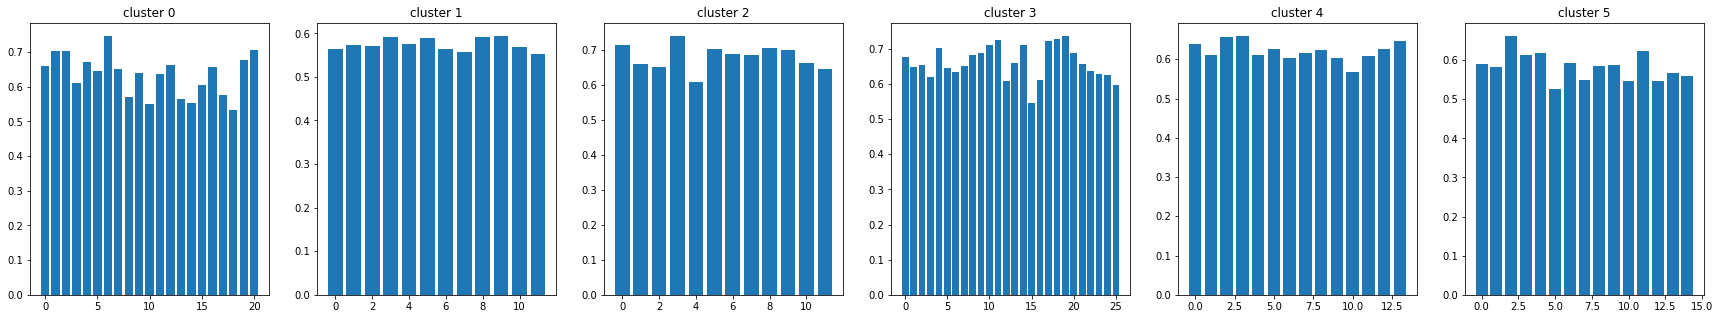

In [52]:
#kmeans
f, axes = plt.subplots(1, len(prf.clusters), figsize=(len(prf.clusters) * 5,5))
for i in range(len(prf.clusters)):
    plot_accuracy(axes[i], prf, i)


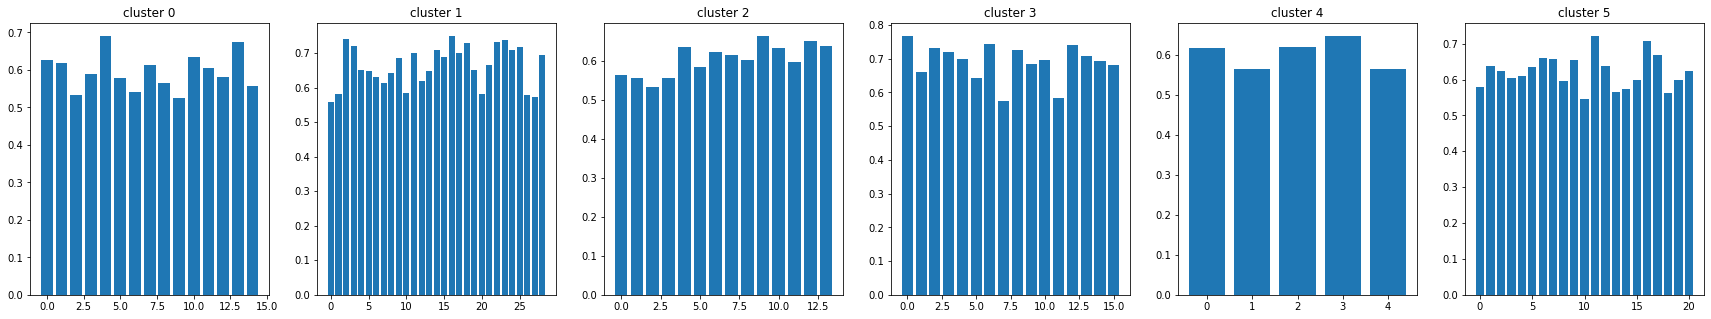

In [53]:
#dbscan
f, axes = plt.subplots(1, len(prf1.clusters), figsize=(len(prf1.clusters) * 5,5))
for i in range(len(prf1.clusters)):
    plot_accuracy(axes[i], prf1, i)

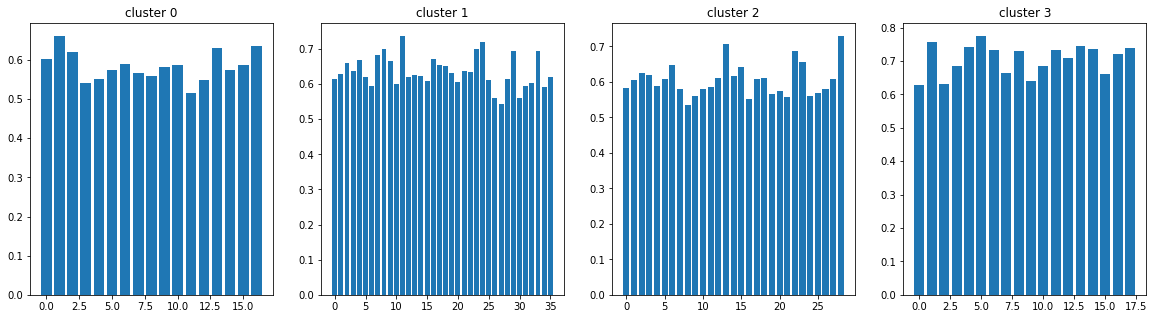

In [54]:
#agglomerative
f, axes = plt.subplots(1, len(prf2.clusters), figsize=(len(prf2.clusters) * 5,5))
for i in range(len(prf2.clusters)):
    plot_accuracy(axes[i], prf2, i)
    

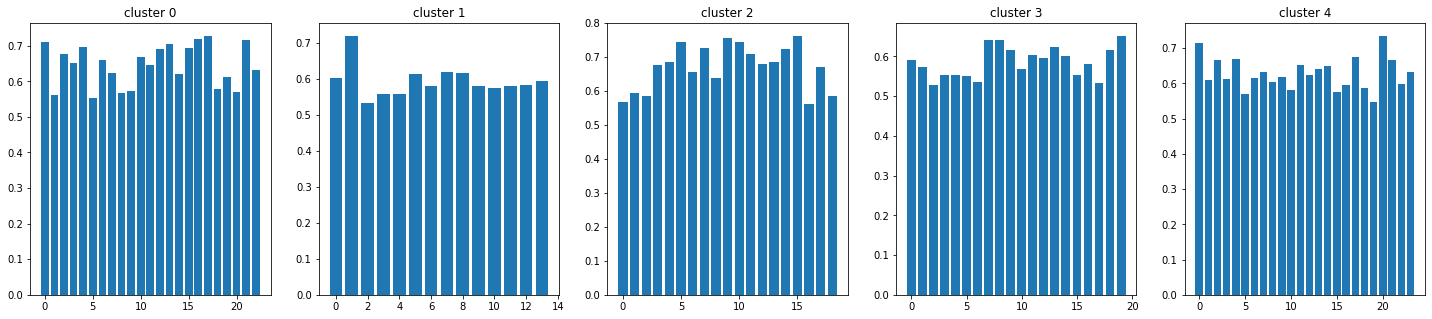

In [55]:
#gaussian
f, axes = plt.subplots(1, len(prf3.clusters), figsize=(len(prf3.clusters) * 5,5))
for i in range(len(prf3.clusters)):
    plot_accuracy(axes[i], prf3, i)

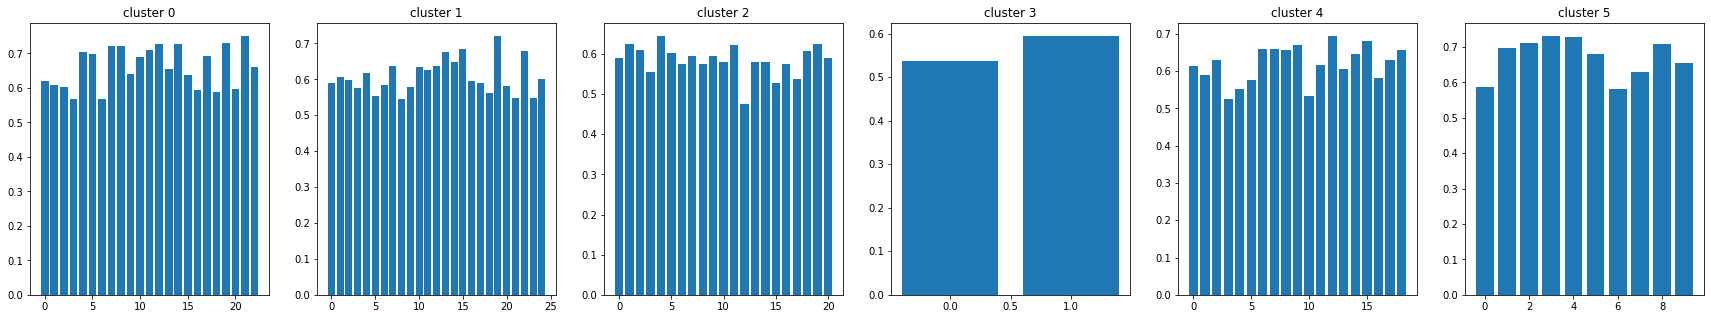

In [56]:
#spectral clusterings
f, axes = plt.subplots(1, len(prf4.clusters), figsize=(len(prf4.clusters) * 5,5))
for i in range(len(prf4.clusters)):
    plot_accuracy(axes[i], prf4, i)

In [57]:
test = np.array([[1, 2], [3, 4], [5, 6]])
test

array([[1, 2],
       [3, 4],
       [5, 6]])

In [58]:
test.shape

(3, 2)